<a href="https://colab.research.google.com/github/geoskimoto/WSOR/blob/main/BasinReports_Formatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Major issues still:
- need to figure out how to chop the htmls into pdfs
- elevations need to be sorted (high to low) for snowpack measurement sites
- nans need to be removed
- need to either hardcore edit forecast table or get plots into app
- "snowpack measurement sites" label needs to be centered vertically
- basin snowpack table needs to renamed to fit the WSOR


#Imports, IO, and Helper Functions

In [1]:
# !pip install xlsxwriter

In [2]:
# !pip install --q dash==2.0.0 jupyter-dash==0.4.0 dash_bootstrap_components pandas;
# !pip install --upgrade openpyxl
# !pip install svglib
from svglib.svglib import svg2rlg
from collections import OrderedDict
from functools import reduce
import datetime as dt
import re
import pandas as pd
import numpy as np
import seaborn as sn
import re
from bs4 import BeautifulSoup as bs

# import dash
# from dash import dcc, html, Input, Output
# from jupyter_dash import JupyterDash
# import dash_table as dashtable
# import dash_bootstrap_components as dbc

     |████████████████████████████████| 896 kB 11.4 MB/s 
     |████████████████████████████████| 2.8 MB 44.6 MB/s 
  Created wheel for svglib: filename=svglib-1.2.1-py3-none-any.whl size=30245 sha256=e5d9c9769570402836c8b14fda8eb84f0c8d2f88aa6817e5797220c5f4f85c10
  Stored in directory: /root/.cache/pip/wheels/9f/52/97/c0661116fd396b64edfce39be6ae515e31a2857c839682f440
Successfully built svglib


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

Mounted at /content/gdrive


In [4]:
cd gdrive

/content/gdrive


In [5]:
cd MyDrive/

/content/gdrive/MyDrive


In [6]:
# cd gdrive/MyDrive/Projects/Work/WSOR
!ls

'app demo pages'		'Forecast Files'
 attr_proj.ipynb		 forecast_plots
 BasinReports_Formatting.ipynb	 OR_BasinMedians_2_2022.html
'Colab Notebooks'		 OR_BasinMedians_2_2022.xlsx
 curriculum_vitae_randomfiles	 OR_BasinReports_1_2022.xlsx
 dbproj				 OR_BasinReports_2_2022.xlsx
 foo.html			 OR_BasinReports_6_2021.xlsx
 foo.pdf			'OWYHEE January 1 2021.png'
 foo.xlsx			'Untitled project.gscript'


# Table Parsing

### Parsing tables for each basin spreadsheet via indices

In [ ]:
#defunct, cumbersome and prone to error...

sheets = [
          # 'BFcst','BRes','BPrecip','BSnow',
          'Rogue-Umpqua',
          'Willamette',
          'Klamath',
          'Hood-Sandy-Lower Deschutes',
          'Upper Deschutes-Crooked',
          'Lake County-Goose Lake',
          'John Day',
          'Harney',
          'Umatilla-Walla Walla-Willow',
          # 'Grande Ronde-Burnt-Powder-Imnaha',
          'Owyhee and Malheur'
          ]

BasinReports = {i:[] for i in sheets}

for sheet in sheets:

  xl = pd.ExcelFile('OR_BasinReports_2_2022.xlsx')
  nrows = xl.book.sheet_by_name(sheet).nrows
  
  if sheet == 'Rogue-Umpqua':
    stream_forecasts = xl.parse(sheet_name=sheet, skiprows=4, skipfooter= nrows-39).replace(np.nan, '', regex=True)
    resv_forecasts = xl.parse(sheet_name=sheet, skiprows=43, skipfooter=nrows-50).replace(np.nan, '', regex=True).iloc[:, :5]
    snowpack = xl.parse(sheet_name=sheet, skiprows=51).replace(np.nan, '', regex=True).iloc[:, :3]
  elif sheet =='Willamette':
    stream_forecasts = xl.parse(sheet_name=sheet, skiprows=4, skipfooter= nrows-50).replace(np.nan, '', regex=True)
    resv_forecasts = xl.parse(sheet_name=sheet, skiprows=54, skipfooter=nrows-70).replace(np.nan, '', regex=True).iloc[:, :5]
    snowpack = xl.parse(sheet_name=sheet, skiprows=72).replace(np.nan, '', regex=True).iloc[:, :3]
 
  elif sheet =='Hood-Sandy-Lower Deschutes':
    stream_forecasts = xl.parse(sheet_name=sheet, skiprows=4, skipfooter= nrows-17).replace(np.nan, '', regex=True)
    resv_forecasts = xl.parse(sheet_name=sheet, skiprows=21, skipfooter=nrows-25).replace(np.nan, '', regex=True).iloc[:, :5]
    snowpack = xl.parse(sheet_name=sheet, skiprows=26).replace(np.nan, '', regex=True).iloc[:, :3]   

  elif sheet =='Lake County-Goose Lake':
    stream_forecasts = xl.parse(sheet_name=sheet, skiprows=4, skipfooter= nrows-17).replace(np.nan, '', regex=True)
    resv_forecasts = xl.parse(sheet_name=sheet, skiprows=21, skipfooter=nrows-25).replace(np.nan, '', regex=True).iloc[:, :5]
    snowpack = xl.parse(sheet_name=sheet, skiprows=27).replace(np.nan, '', regex=True).iloc[:, :3]

  elif sheet =='John Day':
    stream_forecasts = xl.parse(sheet_name=sheet, skiprows=4, skipfooter=nrows-17).replace(np.nan, '', regex=True)
    resv_forecasts = xl.parse(sheet_name=sheet, skiprows=21).replace(np.nan, '', regex=True).iloc[:, :5]
    snowpack = []

  elif sheet =='Harney':
    stream_forecasts = xl.parse(sheet_name=sheet, skiprows=4, skipfooter= nrows-17).replace(np.nan, '', regex=True)
    resv_forecasts = xl.parse(sheet_name=sheet, skiprows=21).replace(np.nan, '', regex=True).iloc[:, :5]
    snowpack = []

  elif sheet =='Umatilla-Walla Walla-Willow':
    stream_forecasts = xl.parse(sheet_name=sheet, skiprows=4, skipfooter= nrows-29).replace(np.nan, '', regex=True)
    resv_forecasts = xl.parse(sheet_name=sheet, skiprows=34, skipfooter=nrows-39).replace(np.nan, '', regex=True).iloc[:, :5]
    snowpack = xl.parse(sheet_name=sheet, skiprows=40).replace(np.nan, '', regex=True).iloc[:, :3]

  # # elif sheet =='Grande Ronde-Burnt-Powder-Imnaha':
  # #   stream_forecasts = xl.parse(sheet_name=sheet, skiprows=4, skipfooter= nrows-39).replace(np.nan, '', regex=True)
  # #   resv_forecasts = xl.parse(sheet_name=sheet, skiprows=43, skipfooter=nrows-50).replace(np.nan, '', regex=True)
  # #   snowpack = xl.parse(sheet_name=sheet, skiprows=51).replace(np.nan, '', regex=True)

  elif sheet =='Owyhee and Malheur':
    stream_forecasts = xl.parse(sheet_name=sheet, skiprows=4, skipfooter= nrows-23).replace(np.nan, '', regex=True)
    resv_forecasts = xl.parse(sheet_name=sheet, skiprows=27, skipfooter=nrows-33).replace(np.nan, '', regex=True).iloc[:, :5]
    snowpack = xl.parse(sheet_name=sheet, skiprows=36).replace(np.nan, '', regex=True).iloc[:, :3]  

  # else:
  #   BasinReports[sheet].append(xl.parse(sheet_name=sheet).replace(np.nan, '', regex=True)

  BasinReports[sheet].append(stream_forecasts)
  BasinReports[sheet].append(resv_forecasts)
  BasinReports[sheet].append(snowpack)
  

    
    # dataframes.append(sheet)

In [ ]:
# # KEEP FOR PROTOTYPING FOR NOW----------------------


# sheets = ['BFcst','BRes','BPrecip','BSnow',
#           'Rogue-Umpqua',
#           'Willamette',
#           'Klamath',
#           'Hood-Sandy-Lower Deschutes',
#           'Upper Deschutes-Crooked',
#           'Lake County-Goose Lake',
#           'John Day',
#           'Harney',
#           'Umatilla-Walla Walla-Willow',
#           # 'Grande Ronde-Burnt-Powder-Imnaha',
#           'Owyhee and Malheur'
#           ]

# BasinReports = {i:[] for i in sheets}
# for i in sheets:
#     sheet = pd.read_excel('OR_BasinReports_1_2022.xlsx', sheet_name=i)
#     # sheet = sheet.replace(np.nan, '', regex=True)
    
#     BasinReports[i].append(sheet)
    
#     # dataframes.append(sheet)



In [ ]:
# Precip = BasinReports['BPrecip'][0]
# Precip.columns = Precip.iloc[1,:]
# Precip[Precip.iloc[:,0] == 'Basin Index'].loc[:,'%\nMedian']

### Parsing using empty rows between tables

In [7]:
# xl = pd.ExcelFile('OR_BasinReports_2_2022.xlsx')

In [8]:
# xl.book.sheetnames

In [18]:
def table_parser(spreadsheet, sheet_name, first_row=0):
  if sheet_name == 'BFcst':
    xl = pd.ExcelFile(spreadsheet)
    BFcst = xl.parse(sheet_name='BFcst')
    # mask = BFcst.apply(lambda x: x.str.contains(r'exceedance', na=False))
    # BFcst.loc[mask.any(axis=1)]

    #Removing unnecessary footers using key word from each bullet point.
    BFcst = BFcst[~BFcst.iloc[:,0].str.contains("exceedance", na=False)]
    BFcst = BFcst[~BFcst.iloc[:,0].str.contains("Forecasts", na=False)]
    BFcst = BFcst[~BFcst.iloc[:,2].str.contains("Forecast", na=False)]

    #Subbasin names are above data in their own row.  Shift them down a row.
    BFcst.iloc[:,0] = BFcst.iloc[:,0].shift(1)

    #Delete rows that are entirely null:
    BFcst.dropna(how='all', inplace=True)

    #Since many rows were dropped and indices inconsistent now, reset them.
    BFcst.reset_index(inplace=True)
    BFcst.drop(columns='index', inplace=True)

    #Define a row to separate basins.  Choosing the header rows that have "Forecast \n Period" in them.
    separator_rows = BFcst[BFcst.iloc[:,1].str.contains("Forecast \n Period", na=False)].index.tolist()
    first_row = 0
    last_row = len(BFcst.index)
    separator_rows.insert(0, first_row)
    separator_rows.append(last_row)

    #Use separator_rows to parse tables.
    basins = [BFcst.loc[separator_rows[i]+1,:][0] for i in range(len(separator_rows)-1)]
    Tables = OrderedDict([basin,[]] for basin in basins)
    for i in range(len(separator_rows[0:-1])):
      try:
        table = BFcst.iloc[separator_rows[i]:separator_rows[i+1], :]
        # table.columns = list(table.iloc[1,0]) + list(table.iloc[0,:])
        table.columns = [table.iloc[1,0], 'Forecast Period', '90% (KAF)', '70% (KAF)', '50% (KAF)', '% Median','30% (KAF)', '10% (KAF)', '30yr Median (KAF)']
        table = table.iloc[2: , :]
        # table.iloc[:,0] = table.iloc[:,0].fillna(method='ffill', axis=0)
        # table.iloc[:,0] = table.iloc[:,0].replace(" ", float('NaN'), inplace=True)
        table.iloc[:,0] = table.iloc[:,0].replace(np.nan,'',regex=True)
        Tables.update({basins[i]:table})
      except:
        pass
    return Tables


  else:
    xl = pd.ExcelFile(spreadsheet)
    sheet = xl.parse(sheet_name=sheet_name)

    #Use indices for empty row breaks between tables to parse tables.
    #First replace empty cells with NaNs
    sheet.replace(np.nan,'',regex=True) 

    #Find indices (i.e. empty rows)
    separator_rows = sheet[sheet.iloc[:,0].isnull()].index.tolist()
    # empty_row_indices_bw_tables = sheet[sheet.iloc[:,0].isnull()].index.tolist()

    #Method above excludes first and last rows, so need to add to list.
    last_row = len(sheet.index) #xl.book.sheet_by_name(sheet_name).nrows 
    separator_rows.insert(0,first_row)
    separator_rows.append(last_row)

    #Grabs names of basins from sheet using empty rows as a reference.
    basins = [sheet.loc[separator_rows[i]+1,:][0] for i in range(len(separator_rows)-1)]
    Tables = OrderedDict([basin,[]] for basin in basins)
    for i in range(len(separator_rows[0:-1])):
      try:
        table = xl.parse(sheet_name=sheet_name, skiprows=separator_rows[i]+2, skipfooter=last_row-separator_rows[i+1]-1).replace(np.nan, '', regex=True)
        
        #Remove "/n" from column indices
        clean_columns = pd.Series(list(table.columns)).replace(r'\n',' ', regex=True).to_list()
        table.columns = clean_columns
        
        Tables.update({basins[i]:table})
      except:
        pass
    #The above for loop excludes the last table, so have to add it in manually for now.
    table = xl.parse(sheet_name=sheet_name, skiprows=separator_rows[-2]+2).replace(np.nan, '', regex=True)
    clean_columns = pd.Series(list(table.columns)).replace(r'\n',' ', regex=True).to_list()
    table.columns = clean_columns

    Tables.update({basins[-1]:table})

    return Tables



# Precip = table_parser('OR_BasinReports_1_2022.xlsx', 'BPrecip', first_row=0)
# Snow['Owyhee and Malheur']

In [10]:

# table = table_parser('OR_BasinReports_2_2022.xlsx', 'Owyhee', first_row=0)
# table = table['Watershed Snowpack Analysis\nFebruary 1, 2022']
# table = table.iloc[:,:4]
# table


In [11]:
# table = table_parser('OR_BasinReports_2_2022.xlsx', 'Malheur', first_row=0)
# [i for i in table.items()][5][1]

In [12]:
# table.items()#['Watershed Snowpack Analysis\nFebruary 1, 2022']

In [13]:
def snowpack_parser(spreadsheet, basin_name):

  table = table_parser(spreadsheet, basin_name, first_row=0)
  if basin_name == 'Malheur':
    index = 5
  else:
    index = 4

  table = [i for i in table.items()][index][1]
  table = table.iloc[:,:4]
  
  return table

In [14]:
sp = snowpack_parser('OR_BasinReports_2_2022.xlsx', 'Owyhee')
sp

,"Watershed Snowpack Analysis February 1, 2022",# of Sites,% Median,Last Year % Median
0,Upper Owyhee,13,88%,55%
1,South Fork Owyhee,6,82%,63%
2,Middle Owhyee,4,121%,66%
3,Jordan,3,97%,75%
4,East Little Owyhee,2,343%,57%


In [15]:
sp.iloc[:,0:4]#.astype(float).round(1)


,"Watershed Snowpack Analysis February 1, 2022",# of Sites,% Median,Last Year % Median
0,Upper Owyhee,13,88%,55%
1,South Fork Owyhee,6,82%,63%
2,Middle Owhyee,4,121%,66%
3,Jordan,3,97%,75%
4,East Little Owyhee,2,343%,57%


In [16]:
# type(sp.iloc[0,2]).round

In [17]:
# sp.loc[2,2].round(1)

# Functions

### Median query function

In [29]:
def median_table(spreadsheet):
  BSnow = table_parser(spreadsheet, 'BSnow')
  BPrecip = table_parser(spreadsheet, 'BPrecip')
  BRes = table_parser(spreadsheet, 'BRes')

  # basin_list = list(BSnow.keys())
  basin_list = ['Owyhee', 'Malheur', 'Grande Ronde-Burnt-Powder-Imnaha', 'Umatilla-Walla Walla-Willow', 'John Day', 'Upper Deschutes-Crooked', 'Hood-Sandy-Lower Deschutes', 'Willamette', 'Rogue-Umpqua', 'Klamath', 'Lake County-Goose Lake', 'Harney']
  snow_medians = []
  for i in basin_list:
    filter = BSnow[i].iloc[:, 0] == 'Basin Index'
    medians = BSnow[i][filter].loc[:,['% Median', 'Last Year % Median']]
    snow_medians.append(medians)

  snow_medians = pd.concat(snow_medians)
  snow_medians.index = basin_list
  snow_medians.columns = ['WTEQ % Median', 'Last Year WTEQ % Median']

  prec_medians = []
  for i in basin_list:
    filter = BPrecip[i].iloc[:, 0] == 'Basin Index'
    medians = BPrecip[i][filter].loc[:,['% Median', '% Median.1']]
    prec_medians.append(medians)

  prec_medians = pd.concat(prec_medians)
  prec_medians.index = basin_list
  prec_medians.columns = ['PPT % Median',  'WYTD PPT % Median']

  #excludes John Day and Harney for reservoirs
  basin_list = ['Owyhee', 'Malheur', 'Grande Ronde-Burnt-Powder-Imnaha', 'Umatilla-Walla Walla-Willow', 'Upper Deschutes-Crooked', 'Hood-Sandy-Lower Deschutes', 'Willamette', 'Rogue-Umpqua', 'Klamath', 'Lake County-Goose Lake']
  res_medians = []
  for i in basin_list:
    filter = BRes[i].iloc[:, 0] == 'Basin Index'
    medians = BRes[i][filter].loc[:,['Median % Capacity',	'Current % Median',	'Last Year % Median']]
    res_medians.append(medians)

  res_medians = pd.concat(res_medians)
  res_medians.index = basin_list
  res_medians.columns = ['Res Median % Capacity',	'Res Current % Median',	'Res Last Year % Median']

  medians = [snow_medians, prec_medians, res_medians]
  medians_df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [medians[j] for j in range(len(medians))])  
  # medians_df.sort_index()
  sorter = ['Owyhee', 'Malheur', 'Grande Ronde-Burnt-Powder-Imnaha', 'Umatilla-Walla Walla-Willow', 'John Day', 'Upper Deschutes-Crooked', 'Hood-Sandy-Lower Deschutes', 'Willamette', 'Rogue-Umpqua', 'Klamath', 'Lake County-Goose Lake', 'Harney']
  medians_df.reset_index(inplace=True)
  medians_df.rename(columns={medians_df.columns[0]: 'Basin'}, inplace=True)

  medians_df.Basin = medians_df.Basin.astype("category").cat.set_categories(sorter)
  # medians_df.sort_values(['Basin'])
  return medians_df.sort_values(['Basin'])

In [30]:
# # sorter = ['Owyhee', 'Malheur', 'Grande Ronde-Burnt-Powder-Imnaha', 'Umatilla-Walla Walla-Willow', 'John Day', 'Upper Deschutes-Crooked', 'Hood-Sandy-Lower Deschutes', 'Willamette', 'Rogue-Umpqua', 'Klamath', 'Lake County-Goose Lake', 'Harney']

# basinmediantable = median_table('OR_BasinReports_2_2022.xlsx')
# # basinmediantable.Basin = basinmediantable.Basin.astype("category").cat.set_categories(sorter)
# # print(basinmediantable.Basin)
# # basinmediantable.sort_values(['Basin'])
# basinmediantable

,Basin,WTEQ % Median,Last Year WTEQ % Median,PPT % Median,WYTD PPT % Median,Res Median % Capacity,Res Current % Median,Res Last Year % Median
7,Owyhee,98%,62%,60%,116%,37%,62%,137%
6,Malheur,83%,94%,71%,82%,21%,62%,167%
0,Grande Ronde-Burnt-Powder-Imnaha,90%,97%,91%,98%,82%,82%,78%
9,Umatilla-Walla Walla-Willow,104%,93%,102%,103%,34%,89%,105%
3,John Day,94%,100%,94%,94%,NaN,NaN,NaN
10,Upper Deschutes-Crooked,92%,89%,83%,93%,68%,46%,58%
2,Hood-Sandy-Lower Deschutes,140%,73%,95%,106%,21%,37%,52%
11,Willamette,124%,76%,90%,102%,37%,85%,84%
8,Rogue-Umpqua,95%,81%,54%,86%,46%,51%,82%
4,Klamath,92%,80%,57%,88%,44%,68%,77%


In [31]:
# basinmediantable.sort_values(['Basin']).to_html('OR_BasinMedians_2_2022.html')

In [32]:
# basinmediantable.sort_values(['Basin']).to_excel('OR_BasinMedians_2_2022.xlsx')

### Forecast stats function

In [33]:
# BFcst = table_parser('OR_BasinReports_2_2022.xlsx', 'BFcst', first_row=0)
# GR = BFcst_reformatted(BFcst, 'Malheur')
# GR.loc[pd.IndexSlice[:, ['APR-SEP']], :]
# # GR

In [34]:
# list(zip([1,2],[1,3],[4,4]))

In [35]:
# BFcst['Grande Ronde-Burnt-Powder-Imnaha']['Grande Ronde-Burnt-Powder-Imnaha']

In [36]:
# BFcst['Owyhee'].replace(r'^\s*$',np.nan,regex=True)

In [37]:
# BFcst['Owyhee'].iloc[1,0]

In [38]:
# BFcst['Owyhee']['Owyhee'].replace(r'^\s*$',np.nan,regex=True)

In [39]:
# r_tuples = list(zip(list(BFcst['Owyhee']['Owyhee'].replace(r'^\s*$',np.nan,regex=True)), list(BFcst['Owyhee'].iloc[:,1])))
# r_tuples

In [40]:
# c = BFcst_reformat(BFcst, 'Grande Ronde-Burnt-Powder-Imnaha').reset_index()
# c.loc[:, 'Subbasin'].ffill(axis=0, inplace=True)
# c

In [41]:
# c.query("Subbasin == 'Lostine R nr Lostine'")

In [42]:
# c[(c['Subbasin'] == 'Lostine R nr Lostine') & (c['Forecast Period'] == 'APR-SEP')]

In [43]:
# c[c['Forecast Period'] == 'APR-SEP']

In [44]:
# basin_BFcst[basin_BFcst['Forecast Period' == forecast_period]]

In [45]:
# c['% Median']

In [46]:
# BFcst_reformat(BFcst, 'Grande Ronde-Burnt-Powder-Imnaha').loc['Grande Ronde-Burnt-Powder-Imnaha',:].loc['APR-JUL',:]

In [47]:
#----------KEEP for reference----------
#https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe

# Queries only the Subbasin Index and only returns first row:
# GR.loc[['Lostine R nr Lostine']]
# same as:
# GR.query("Subbasin == 'Lostine R nr Lostine'")
# same as: 
# GR.xs('Lostine R nr Lostine', level=0, axis=0, drop_level=False)
# same as:
# GR[GR.index.get_level_values('Subbasin') == 'Lostine R nr Lostine']

# Queries only the Forecast Period Index
# GR.xs('APR-SEP', level=1, axis=0, drop_level=False)
#same as:
# GR[GR.index.get_level_values('Forecast Period') == 'APR-SEP']
#same as:
# idx = pd.IndexSlice
# GR.loc[idx[:, 'APR-SEP'], :]
#same as:
# GR.query("Forecast Period == 'APR-SEP'") #according to above link, this should work.  Not working for some reason though.

#------------------

def BFcst_reformat(BFcst, basin_name):

#INDICES
  # r_tuples = list(zip(list(BFcst[basin_name].iloc[:,0]), list(BFcst[basin_name].iloc[:,1])))
  basin_name_duplicated = [[i]*len(BFcst[basin_name].iloc[:,0]) for i in [basin_name]][0]
  subbasin_names = list(BFcst[basin_name][basin_name].replace(r'^\s*$',np.nan,regex=True))  #replace empty strings with nan so subbasin names can later be forward filled with pd.ffill().
  forecast_period_names = list(BFcst[basin_name].iloc[:,1])
  r_tuples = list(zip(basin_name_duplicated, subbasin_names, forecast_period_names))  
  # c_tuples = [
  #             ('',BFcst[basin_name].columns[0]),
  #             ('','Forecast Period'),
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '90% (KAF)'),
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '70% (KAF)'), 
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '50% (KAF)'), 
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '% Median'), 
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '30% (KAF)'), 
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '10%(KAF)'), 
  #             ('', '30yr Median(KAF)')
  #             ]
  
  c_tuples = [
              (BFcst[basin_name].columns[0]),
              ('Forecast Period'),
              ('90% (KAF)'),
              ('70% (KAF)'), 
              ('50% (KAF)'), 
              ('% Median'), 
              ('30% (KAF)'), 
              ('10%(KAF)'), 
              ('30yr Median(KAF)')
              ]
  
  index = pd.MultiIndex.from_tuples(r_tuples) 
  index.set_names(['Basin', 'Subbasin', 'Forecast Period'], inplace=True)
  columns = c_tuples
  # df = BFcst[basin_name].copy()
  # df.replace("", float('NaN'), inplace=True)
  # df.dropna(inplace=True)
  df = pd.DataFrame(BFcst[basin_name].to_numpy(), columns=columns, index=index)
  # df.reset_index(inplace=True)
  # df.set_index(df.loc[:,''][basin_name], inplace=True)
  # df.loc[0] = ['Streamflow Forecasts for ' + str(dt.datetime.now().strftime("%B %Y")), 'Forecast Period', '90% (KAF)', '70% (KAF)', '50% (KAF)', '% Median', '30% (KAF)', '10% (KAF)', '30yr Median (KAF)'
              # ]  
  # df.columns = ['','  d','←-----','Drier','-----','Future Conditions','-----','Wetter', '-------→'] 
  # df.index = df.iloc[:,0]
  df = df.iloc[:,2:]

  return df

def BFcst_Stats(BFcst, basin_name, forecast_period):
  basin_BFcst = BFcst_reformat(BFcst, basin_name).reset_index()
  basin_BFcst.loc[:, 'Subbasin'].ffill(axis=0, inplace=True)

  medians = basin_BFcst[basin_BFcst['Forecast Period'] == forecast_period]#['Subbasin', '% Median']            #basin_BFcst.loc[pd.IndexSlice[:, [forecast_period]], :]['% Median']
  # medians.mean()
  medians2 = medians['% Median'].str.rstrip('%').astype('float')
  mean = medians2.mean()
  median = medians2.median()
  max = medians2.max()
  min = medians2.min()

  medians_df = pd.DataFrame(medians)
  # r_tuples = ()
  # index = pd.MultiIndex.from_tuples(c_tuples)

  # medians_df.droplevel(level=0)
  # medians = {'Basin': basin_name, 'Medians': medians} 
  # medians_stats_df = pd.DataFrame({'Mean':[mean], 'Median':[median], 'max':[max], 'min':[min]})
  medians_stats = {'Basin': basin_name, 'Median':median, 'Mean':mean, 'Max':max, 'Min':min}
  # medians_df.index = [basin_name]

  return medians_df, medians_stats

def BFcst_Stats_allbasins(BFcst, forecast_period):
  
  forecasts_allbasins = []
  forecast_stats_allbasins = []
  for basin in BFcst.keys():
    medians, median_stats = BFcst_Stats(BFcst, basin, forecast_period)    
    forecasts_allbasins.append(medians)
    forecast_stats_allbasins.append(median_stats)
  
  # forecast_all_basins = pd.concat(forecasts_allbasins)
  forecast_stats_allbasins = pd.DataFrame(forecast_stats_allbasins)#.set_index('Basin')
  sorter = ['Owyhee', 'Malheur', 'Grande Ronde-Burnt-Powder-Imnaha', 'Umatilla-Walla Walla-Willow', 'John Day', 'Upper Deschutes-Crooked', 'Hood-Sandy-Lower Deschutes', 'Willamette', 'Rogue-Umpqua', 'Klamath', 'Lake County-Goose Lake', 'Harney']
  forecast_stats_allbasins.Basin = forecast_stats_allbasins.Basin.astype("category").cat.set_categories(sorter)
  forecast_stats_allbasins = forecast_stats_allbasins.sort_values(['Basin'])

  return pd.concat(forecasts_allbasins), forecast_stats_allbasins

In [48]:
a,b = BFcst_Stats(BFcst, 'Malheur', 'APR-SEP')

NameError: ignored

In [ ]:
a.T

In [ ]:
b

In [ ]:
a,b = BFcst_Stats_allbasins(BFcst, 'APR-SEP')

In [ ]:
a

In [ ]:
b

In [ ]:
# import plotly.express as px

# df = a[a['Subbasin']=='Owyhee R nr Rome'][['90% (KAF)', '70% (KAF)', '50% (KAF)', '30% (KAF)', '10%(KAF)']].T
# df.columns =['basin']
# fig = px.bar(df, x="basin", y='basin', title="Long-Form Input")
# fig.show()

In [ ]:
b

In [ ]:
medians_df, medians_stats_df = BFcst_Stats(BFcst, 'Owyhee', 'APR-SEP')

In [ ]:
medians_df['Medians']

In [ ]:
medians_stats_df

In [ ]:
# idx = pd.IndexSlice
# slice_= [idx[:, 'APR-SEP'], idx[:]]
# # BFcst['Grande Ronde-Burnt-Powder-Imnaha']
# GR.loc[1,:] #['Forecast Period']

# BeautifulSoup - editing table html strings

In [ ]:
BSnow['Grande Ronde-Burnt-Powder-Imnaha'].to_html(notebook=True)

'<div>\n<style scoped>\n    .dataframe tbody tr th:only-of-type {\n        vertical-align: middle;\n    }\n\n    .dataframe tbody tr th {\n        vertical-align: top;\n    }\n\n    .dataframe thead th {\n        text-align: right;\n    }\n</style>\n<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Grande Ronde-Burnt-Powder-Imnaha</th>\n      <th>Network</th>\n      <th>Elevation (ft)</th>\n      <th>Depth (in)</th>\n      <th>SWE (in)</th>\n      <th>Median (in)</th>\n      <th>% Median</th>\n      <th>Last Year SWE (in)</th>\n      <th>Last Year % Median</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>Aneroid Lake #2</td>\n      <td>SNOTEL</td>\n      <td>7400.0</td>\n      <td>33.0</td>\n      <td>9.3</td>\n      <td>12.4</td>\n      <td>75%</td>\n      <td>11.5</td>\n      <td>93%</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>Anthony Lake (Rev)</td>\n      <td>SC</td>\n      <td>71

In [ ]:
BSnow['Grande Ronde-Burnt-Powder-Imnaha'].to_html(notebook=False)

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Grande Ronde-Burnt-Powder-Imnaha</th>\n      <th>Network</th>\n      <th>Elevation (ft)</th>\n      <th>Depth (in)</th>\n      <th>SWE (in)</th>\n      <th>Median (in)</th>\n      <th>% Median</th>\n      <th>Last Year SWE (in)</th>\n      <th>Last Year % Median</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>Aneroid Lake #2</td>\n      <td>SNOTEL</td>\n      <td>7400.0</td>\n      <td>33.0</td>\n      <td>9.3</td>\n      <td>12.4</td>\n      <td>75%</td>\n      <td>11.5</td>\n      <td>93%</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>Anthony Lake (Rev)</td>\n      <td>SC</td>\n      <td>7160.0</td>\n      <td>44.0</td>\n      <td>14.8</td>\n      <td>15.0</td>\n      <td>99%</td>\n      <td>13.0</td>\n      <td>87%</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>Bald Mtn Am OR</td>\n      <td>SC</td>\n      <td>6600.0</td>\n  

In [ ]:
soup = bs(BSnow['Grande Ronde-Burnt-Powder-Imnaha'].to_html(), 'html.parser')

In [ ]:
soup.find_all('class')

[]

In [ ]:
soup

<table border="1" class="dataframe">
<thead>
<tr style="text-align: right;">
<th></th>
<th>Grande Ronde-Burnt-Powder-Imnaha</th>
<th>Network</th>
<th>Elevation (ft)</th>
<th>Depth (in)</th>
<th>SWE (in)</th>
<th>Median (in)</th>
<th>% Median</th>
<th>Last Year SWE (in)</th>
<th>Last Year % Median</th>
</tr>
</thead>
<tbody>
<tr>
<th>0</th>
<td>Aneroid Lake #2</td>
<td>SNOTEL</td>
<td>7400.0</td>
<td>33.0</td>
<td>9.3</td>
<td>12.4</td>
<td>75%</td>
<td>11.5</td>
<td>93%</td>
</tr>
<tr>
<th>1</th>
<td>Anthony Lake (Rev)</td>
<td>SC</td>
<td>7160.0</td>
<td>44.0</td>
<td>14.8</td>
<td>15.0</td>
<td>99%</td>
<td>13.0</td>
<td>87%</td>
</tr>
<tr>
<th>2</th>
<td>Bald Mtn Am OR</td>
<td>SC</td>
<td>6600.0</td>
<td>57.0</td>
<td>16.5</td>
<td>18.2</td>
<td>91%</td>
<td>16.2</td>
<td>89%</td>
</tr>
<tr>
<th>3</th>
<td>Barney Creek (New)</td>
<td>SC</td>
<td>5830.0</td>
<td>25.0</td>
<td>6.6</td>
<td>6.2</td>
<td>106%</td>
<td>6.8</td>
<td>110%</td>
</tr>
<tr>
<th>4</th>
<td>Bear Saddle</td>
<t

## Try plotting with matplotlib and then saving as pdf??


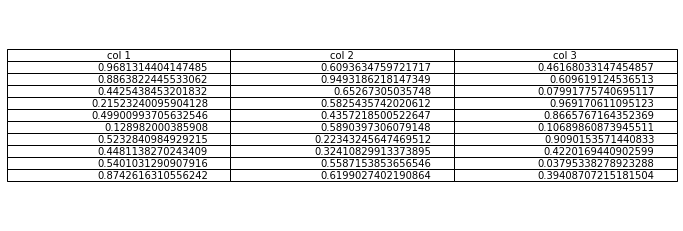

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

df = pd.DataFrame(np.random.random((10,3)), columns = ("col 1", "col 2", "col 3"))

#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("foo.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

#GROSS...PROBABLY NOT

## Formating experimenting

In [19]:
BFcst = table_parser('OR_BasinReports_2_2022.xlsx', 'BFcst', first_row=0)
BRes = table_parser('OR_BasinReports_2_2022.xlsx', 'BRes', first_row=0)
BSnow = table_parser('OR_BasinReports_2_2022.xlsx', 'BSnow', first_row=0)
BPrec = table_parser('OR_BasinReports_2_2022.xlsx', 'BPrecip', first_row=0)

####Bootstrap

In [ ]:
# from IPython.display import HTML

In [ ]:
# HTML(BSnow['Hood-Sandy-Lower Deschutes'].to_html(classes=["table-bordered", "table-striped", "table-hover"]))

ModuleNotFoundError: ignored

#### General table formatting

In [ ]:
# def highlight_cols(s):
#     color = 'grey'
#     return 'background-color: %s' % color

# s = BSnow['Hood-Sandy-Lower Deschutes'].style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['Median (in)', 'SWE (in)']])

s = BRes['Hood-Sandy-Lower Deschutes'].iloc[:-2].set_index('Hood-Sandy-Lower Deschutes').style.format()
s

,Current (KAF),Last Year (KAF),Median (KAF),Capacity (KAF),Current % Capacity,Last Year % Capacity,Median % Capacity,Current % Median,Last Year % Median
Hood-Sandy-Lower Deschutes,,,,,,,,,
Clear Lake,1.035000,1.451000,2.800000,13.100000,8%,11%,21%,37%,52%
Basin Index,1.040000,1.450000,2.800000,13.100000,8%,11%,21%,37%,52%


In [ ]:
# def BFcst_format(BFcst, basin_name):
#   # BFcst = BFcst_reformatted(BFcst, basin_name)
#   BFcst = BFcst[basin_name]
#   BFcst.rename(columns={basin_name : "Streamflow Forecast"})
#   s = BFcst.style.format()  #.set_index('Hood-Sandy-Lower Deschutes')
 
#   cell_hover = {  # for row hover use <tr> instead of <td>
#       'selector': 'td:hover',
#       'props': [('background-color', 'grey')]
#   }
#   index_name = {
#       'selector': '.index_name',
#       'props': 'font-style: normal; color: black; font-weight:900;'
#   }
#   headers = {
#       'selector': 'th:not(.index_name)',
#       'props': 'background-color: light grey; color: black;'
#   }
#   s.set_properties(**{'border': '1.3px solid white',
#                           'color': 'black',
#                           'background-color':'white'})

#   s.set_properties(subset=pd.IndexSlice[:, ['50% (KAF)',	'% Median']], **{'border': '1.3px solid grey',
#                             'color': 'black',
#                             'background-color':'grey'})
  
#   # s.set_properties('display float format', '{:.2f}')

#   s.set_table_styles([cell_hover, index_name, headers])

#   return s

In [ ]:
# BFcst_format(BFcst, 'Grande Ronde-Burnt-Powder-Imnaha')

In [ ]:
s = BFcst_reformatted(BFcst, 'Malheur')

col_loc_add = s.columns.get_loc(symbol)
col_loc_add


array([False, False,  True,  True,  True,  True,  True,  True, False])

### style_BFcst

In [43]:
def style_BFcst(BFcst, basin_name):

#INDICES
  # r_tuples = list(zip(list(BFcst[basin_name].iloc[:,0]), list(BFcst[basin_name].iloc[:,1])))
  symbol = '<-------Drier----------Future Conditions--------Wetter------->'
  c_tuples = [
              (' ','Streamflow Forecasts'),
              (' ','Forecast Period'),
              (symbol, '90% (KAF)'),
              (symbol, '70% (KAF)'), 
              (symbol, '50% (KAF)'), 
              (symbol, '% Median'), 
              (symbol, '30% (KAF)'), 
              (symbol, '10% (KAF)'), 
              (' ', '30yr Median (KAF)')
              ]
  
  columns = pd.MultiIndex.from_tuples(c_tuples)
  # columns = c_tuples
  # df = BFcst[basin_name].copy()
  # df.replace("", float('NaN'), inplace=True)
  # df.dropna(inplace=True)
  df = pd.DataFrame(BFcst[basin_name].to_numpy(), columns=columns)
  df.replace("", float('NaN'), inplace=True)
  f = {
       (symbol,'90% (KAF)'):'{:.0f}', 
       (symbol, '70% (KAF)'):'{:.0f}',	
       (symbol, '50% (KAF)'):'{:.0f}',	
       (symbol,'30% (KAF)'):'{:.0f}',	
       (symbol, '10% (KAF)'):'{:.0f}',	
       (' ', '30yr Median (KAF)'):'{:.0f}'
       }
  s = df.style.format(f)  #.set_index('Hood-Sandy-Lower Deschutes')
  
  cell_hover = {  # for row hover use <tr> instead of <td>
      'selector': 'tr:hover',
      'props': [('background-color', 'red')]
  }
  index_name = {
      'selector': '.index_name',
      'props': 'font-style: normal; color: black; font-weight:900;'
  }

  headers = [
            {'selector': 'th:not(.index_name)','props': 'background-color: white; color: black;'},
            {'selector': 'th.col_heading', 'props': 'text-align: center;'},
            {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.2em;'},
            {'selector': 'th.col_heading.level1', 'props': 'font-size: 1.3em;'},
            {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
            # {'selector': 'th:nth-child(1)','props': [('background-color', '#D3D3D3')]},
            {'selector': 'th:nth-child(5)','props': [('background-color', '#D3D3D3')]},
            {'selector': 'th:nth-child(6)','props': [('background-color', '#D3D3D3')]},

            # {'selector': 'th:nth-child(2)','props': [('border-right', '2.5px solid black')]},
            # {'selector': 'th:nth-child(2)','props': [('border-left', '2.5px solid black')]},

            #  {'selector': 'th:nth-child(1)','props': [('border-right', '2.5px solid black')]},
            #  {'selector': 'th:nth-child(1)','props': [('background-color', '#D3D3D3')]},

  ]
  # all_table = {'selector': 'table',
  #            'props': 'border: 15px solid red; border-collapse: collapse'                    
  # }

  all_table = {"selector": "", "props": [("border", "5px solid black")]}  #bit of a hack to give a table a border; unconventional way to do it with an empty selector.

  s.set_properties(**{'border': '1.3px solid white',
                          'color': 'black',
                          'background-color':'white'})

  # def highlight_max(s, props=''):
  #     return np.where(s == np.nanmax(s.values), props, '')

  idx = pd.IndexSlice
  #for multiindex/multicolumns use this template for slicing
  slice_ = idx[idx[:,:], idx[:,['50% (KAF)', '% Median']]]

  slice_ = idx[idx[:], idx[symbol,['50% (KAF)', '% Median']]]
  s.set_properties(subset=slice_, **{'border': '1.3px solid #D3D3D3',
                                    'color': 'black',
                                    'background-color':'#D3D3D3'})


  slice_ = idx[idx[:], idx[' ',['30yr Median(KAF)']]]
  s.set_properties(subset=slice_, **{'border-left': '2px solid black'})

  slice_ = idx[idx[0], idx[:,:]]
  s.set_properties(subset=slice_, **{'border-top': '2.5px solid black'})

  slice_ = idx[idx[:], idx[' ',['Forecast Period']]]
  s.set_properties(subset=slice_, **{'border-right': '2.5px solid black',
                                    'border-left': '2.5px solid black'})

  # s.applymap_index(lambda v: "background:#D3D3D3;" if v=='Owyhee' else "color:darkblue;", axis=0)

  # s.apply(highlight_max, props='color:blue;', axis=0, subset=slice_)

  # s.style.apply(highlight_max, props='color:red;', axis=0, subset=slice_)

  # s.set_properties(subset=[idx[:,:], idx['50% (KAF)',	'% Median']], **{'border': '1.3px solid grey',
  #                           'color': 'black',
  #                           'background-color':'grey'})

  s.set_table_styles([cell_hover, index_name, all_table])
  s.set_table_styles(headers)
  s.hide_index()

  # s.bar(subset=idx[idx[:], idx[symbol,['50% (KAF)']]], color='#d65f5f')

  return s


#-----------Other available table css properties-------------------

#border-collapse: collapse   - removes the padding between cells when using .to_html
#vertical-align
#border-color: inherit
#background: blue
#border-left:2px solid red

In [44]:
basins = [
          'Rogue-Umpqua',
          'Willamette',
          'Klamath',
          'Hood-Sandy-Lower Deschutes',
          'Upper Deschutes-Crooked',
          'Lake County-Goose Lake',  
          'Umatilla-Walla Walla-Willow',
          'Grande Ronde-Burnt-Powder-Imnaha',
          'Owyhee',
          'Malheur',
          'John Day',
          'Harney'
          ]
bla=[]
for i in basins:
  # print(str(i))
  bla.append(style_BFcst(BFcst, i))

bla[9]
# bla[6]

In [46]:
bla[5].data#.iloc[4,4]

... <-------Drier----------Future Conditions--------Wetter------->                  
     Streamflow Forecasts Forecast Period  ...                                                      10% (KAF) 30yr Median (KAF)
0   Twentymile Ck nr Adel         MAR-JUL  ...                                                 41                          18.9
1                     NaN         APR-SEP  ...                                                 25                          12.1
2  Chewaucan R nr Paisley         MAR-JUL  ...                                                109                          71.0
3                     NaN         APR-SEP  ...                                                101                          66.0
4         Deep Ck ab Adel         MAR-JUL  ...                                                115                          62.0
5                     NaN         APR-SEP  ...                                                 98                          52.0
6       Honey Ck nr Plush         MAR-JUL  ...                                                 25                          10.0
7                     NaN         APR-SEP  ...                                                 22                           8.5

[8 rows x 9 columns]

In [ ]:
table.data.xs('90% (KAF)', axis=1, level=1)

,←-------Drier----------Future Conditions--------Wetter-------→
0,445
1,305
2,31
3,16.9
4,4.7
5,4.9
6,69
7,50


In [ ]:
table.to_html()

'<style type="text/css">\n#T_9ac6b_ th:not(.index_name) {\n  background-color: white;\n  color: black;\n}\n#T_9ac6b_ th.col_heading {\n  text-align: center;\n}\n#T_9ac6b_ th.col_heading.level0 {\n  font-size: 1.2em;\n}\n#T_9ac6b_ th.col_heading.level1 {\n  font-size: 1.3em;\n}\n#T_9ac6b_ td {\n  text-align: center;\n  font-weight: bold;\n}\n#T_9ac6b_ th:nth-child(1) {\n  background-color: #D3D3D3;\n}\n#T_9ac6b_ th:nth-child(5) {\n  background-color: #D3D3D3;\n}\n#T_9ac6b_ th:nth-child(6) {\n  background-color: #D3D3D3;\n}\n#T_9ac6b_row0_col0, #T_9ac6b_row0_col2, #T_9ac6b_row0_col3, #T_9ac6b_row0_col6, #T_9ac6b_row0_col7 {\n  border: 1.3px solid white;\n  color: black;\n  background-color: white;\n  border-top: 2.5px solid black;\n}\n#T_9ac6b_row0_col1 {\n  border: 1.3px solid white;\n  color: black;\n  background-color: white;\n  border-top: 2.5px solid black;\n  border-right: 2.5px solid black;\n  border-left: 2.5px solid black;\n}\n#T_9ac6b_row0_col4, #T_9ac6b_row0_col5 {\n  border: 

### style_Res

In [113]:
def style_Res(BRes, basin_name):
  global df2, df
  df = BRes[basin_name]#.loc[:,[f'{basin_name}', 'Current (KAF)', 'Last Year (KAF)',	'Median (KAF)',	'Median % Capacity', 'Capacity (KAF)']]
  df = df.iloc[:-3,:].copy()
  df.rename(columns={f'{basin_name}':'Reservoir Storage', 	'Median % Capacity': '% of Median', 'Capacity (KAF)': 'Usable Capacity (KAF)'}, inplace=True)

  # #Got to be a better way to round these values; have to create whole new dataframe using df.round().  df.apply(np.round) would work but can't specify # of decimals.  So stupid.
  # # df.set_index('Reservoir Storage', inplace=True)
  try:
    df2 = df[['Current (KAF)', 'Last Year (KAF)', 'Median (KAF)', 'Usable Capacity (KAF)']].astype(float).round(1)
  except:
    df2 = df[['Current (KAF)', 'Last Year (KAF)', 'Median (KAF)', 'Usable Capacity (KAF)']]

  df2.insert(3,'% of Median', np.array(df['% of Median']))
  df2.insert(0,'Reservoir Storage', np.array(df['Reservoir Storage']))

  #Round values when styling!!!! 
  # df.replace("", float('NaN'), inplace=True)
  # f = {'Current (KAF)':'{:.2f}', 'Last Year (KAF)':'{:.3}', 'Median (KAF)':'{:.3}', 'Usable Capacity (KAF)':'{:.2f}'}
  # s = df2.style.format()

  ## Headers
  # headers = [
  #             {'selector': 'th:not(.index_name)','props': 'background-color: white; color: black;'},
  #             {'selector': 'th.col_heading', 'props': 'text-align: center;'},
  #             {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.2em;'},
  #             {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
  #             {'selector': 'th:nth-child(1)','props': [('background-color', '#D3D3D3'), ('border-right', '2.5px solid black')]},
  # ]
  # s.set_table_styles(headers)

  # ## Cells
  # #set cell color to white, background to white, text color to black:
  # s.set_properties(**{'border': '1.3px solid white',
  #                       'color': 'black',
  #                       'background-color':'white'})  
  # idx = pd.IndexSlice
  # slice_ = idx[0, :]
  # s.set_properties(subset=slice_, **{'border-top': '2.5px solid black'})

  # slice_ = idx[:, 'Reservoir Storage']
  # s.set_properties(subset=slice_, **{'border-right': '2.5px solid black'})

  # slice_ = df.columns #idx[idx[:], idx[symbol,['50% (KAF)', '% Median']]]
  # s.set_properties(subset=slice_, **{'border': '1.3px solid #D3D3D3',
  #                                   'color': 'black',
  #                                   'background-color':'#D3D3D3'})


  # s.hide_index()  
  return df2

In [114]:
style_Res(BRes, 'Lake County-Goose Lake') #.to_html()


,Reservoir Storage,Current (KAF),Last Year (KAF),Median (KAF),% of Median,Usable Capacity (KAF)
0,Cottonwood,0.975,0.426,3.5,38%,9.3
1,Drews,2.27,,25.6,40%,63.5


In [106]:
df2

,Reservoir Storage,Current (KAF),Last Year (KAF),Median (KAF),% of Median,Usable Capacity (KAF)
0,Cottonwood,0.975,0.426,3.5,38%,9.3
1,Drews,2.27,,25.6,40%,63.5


In [107]:
basins = [
          'Rogue-Umpqua',
          'Willamette',
          'Klamath',
          'Hood-Sandy-Lower Deschutes',
          'Upper Deschutes-Crooked',
          'Lake County-Goose Lake',  
          'Umatilla-Walla Walla-Willow',
          'Grande Ronde-Burnt-Powder-Imnaha',
          # 'Owyhee',
          # 'John Day',
          'Malheur'
          ]
bla=[]
for i in basins:
  # print(str(i))
  bla.append(style_Res(BRes, i))

In [108]:
bla[5]

Reservoir Storage,Current (KAF),Last Year (KAF),Median (KAF),% of Median,Usable Capacity (KAF)
Cottonwood,0.975000,0.426000,3.500000,38%,9.300000
Drews,2.270000,,25.600000,40%,63.500000


In [74]:
# # df = BRes['Hood-Sandy-Lower Deschutes']
# basin = 'Lake County-Goose Lake' #'Willamette'#John Day'#'Rogue-Umpqua'
# df = BRes[basin]
# # df = BRes[basin_name].loc[:,[f'{basin_name}', 'Current (KAF)', 'Last Year (KAF)',	'Median (KAF)',	'Median % Capacity', 'Capacity (KAF)']]
# df = df.iloc[:-3,:].copy()
# df.rename(columns={basin:'Reservoir Storage', 	'Median % Capacity': '% of Median', 'Capacity (KAF)': 'Usable Capacity (KAF)'}, inplace=True)

# # # #Got to be a better way to round these values; have to create whole new dataframe using df.round().  df.apply(np.round) would work but can't specify # of decimals.  So stupid.
# # # # df.set_index('Reservoir Storage', inplace=True)
# try:
#   df2 = df[['Current (KAF)', 'Last Year (KAF)', 'Median (KAF)', 'Usable Capacity (KAF)']].astype(float).round(1)
# except:
#   df2 = df[['Current (KAF)', 'Last Year (KAF)', 'Median (KAF)', 'Usable Capacity (KAF)']]
# df2.insert(3,'% of Median', np.array(df['% of Median']))
# df2.insert(0,'Reservoir Storage', np.array(df['Reservoir Storage']))
# df2

In [ ]:
# df['Current (KAF)'].apply(np.round)

In [ ]:
# df['Current (KAF)'].astype(float)==True

### style_Snow

In [ ]:
# # Can likely use this to round numbers before styling.  

# def round_float(s):
#   m = re.match("(\d+\.\d+)",s.__str__())
#   try:
#       r = round(float(m.groups(0)[0]),0)
#   except:
#       r = s
#   return r

# BSnow['Umatilla-Walla Walla-Willow']['SWE (in)'].apply(round_float)

In [106]:
def style_Snow(BSnow, basin_name):
  
  # c_tuples = [
  #             ('Basin Snowpack Measurement Sites', 'Basin Snowpack Measurement Sites'),
  #             ('Network', 'Network'),
  #             ('Elevation (ft)', 'Elevation (ft)'),
  #             ('Snow Depth (ft)', 'Snow Depth (ft)'),
  #             ('Snow Water Equivalent (in)', 'Current SWE'),
  #             ('Snow Water Equivalent (in)', 'Median'),
  #             ('Snow Water Equivalent (in)', 'Last Yr SWE'),
  #             ('Snow Water Equivalent (in)', '% of Median')
  #             ]
  c_tuples = [
              ('Basin Snowpack Measurement Sites', ''),
              ('', 'Network'),
              ('', 'Elevation (ft)'),
              ('', 'Snow Depth (in)'),
              ('Snow Water Equivalent (in)', 'Current SWE (in)'),
              ('Snow Water Equivalent (in)', 'Median (in)'),
              ('Snow Water Equivalent (in)', 'Last Yr SWE (in)'),
              ('Snow Water Equivalent (in)', '% of Median'),
              # ('','')
              ]
  
  columns = pd.MultiIndex.from_tuples(c_tuples)
  df = BSnow[basin_name].iloc[:-3,:].copy()
  df = df[(df['Network'] != 'SNOWLITE') & (df['Network'] != 'SNOLITE')]
  # df['Elevation (ft)'].astype(float)
  df.sort_values(by=['Elevation (ft)'], inplace=True, ascending=False)
  df = pd.DataFrame(df.loc[:,[f'{basin_name}', 'Network',	'Elevation (ft)',	'Depth (in)',	'SWE (in)',	'Median (in)', 'Last Year SWE (in)', '% Median']].to_numpy(), columns=columns)
 
  df.replace("", float('NaN'), inplace=True)
  f = {
        ('', 'Elevation (ft)'): '{:.0f}',
        ('', 'Snow Depth (in)'): '{:.0f}',
        ('Snow Water Equivalent (in)', 'Current SWE (in)'): '{:.1f}',
        ('Snow Water Equivalent (in)', 'Median (in)'): '{:.1f}',
        ('Snow Water Equivalent (in)', 'Last Yr SWE (in)'): '{:.1f}',
      }
  s = df.style.format(f)

  ## Headers
  headers = [
              {'selector': 'th:not(.index_name)','props': 'background-color: white; color: black'},
              # {'selector': 'th.col_heading', 'props': 'text-align': 'center'},
              {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.2em; text-align: center'},
              {'selector': 'th.col_heading.level1', 'props': 'font-size: 1.05em; font-weight: bold'},
              {'selector': 'th:not(.index_name)','props': 'background-color: white; color: black'},
              # {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
              {'selector': 'th:nth-child(1)','props': [('background-color', '#D3D3D3'), ('border-right', '2.5px solid black')]},
              {'selector': 'th:nth-child(5)','props': [('border-left', '2.5px solid black')]},
  ]
  s.set_table_styles(headers)

  ## Cells
  #set cell color to white, background to white, text color to black:
  s.set_properties(**{'border': '1.3px solid white',
                        'color': 'black',
                        'font-weight': 'bold',
                        'background-color':'white'})  
  #border under headings
  idx = pd.IndexSlice
  slice_ = idx[0, :]
  s.set_properties(subset=slice_, **{'border-top': '2.5px solid black'})


  #border right of first column, right align text and make bold.
  slice_ = idx[:, [('Basin Snowpack Measurement Sites', '')]]  #
  s.set_properties(subset=slice_, **{'border-right': '2.5px solid black',
                                    'text-align': 'right',
                                    #  'font-weight': 'bold',
                                    #  'vertical-align': 'middle'
                                     }
                   )

  slice_ = idx[:, [('', 'Network'), 
                   ('', 'Elevation (ft)'), 
                   ('', 'Snow Depth (in)'),	
                   ('Snow Water Equivalent (in)', 'Current SWE (in)'),
                   ('Snow Water Equivalent (in)', 'Median (in)'),
                   ('Snow Water Equivalent (in)', 'Last Yr SWE (in)'),
                   ('Snow Water Equivalent (in)', '% of Median')
                   ]]  #
  
  s.set_properties(subset=slice_, **{'text-align': 'center',
                                     'font-weight': 'bold'
                                      #  'vertical-align': 'middle'
                                      }
                   )
  
  
  slice_ = idx[:, [
                   ('Snow Water Equivalent (in)', 'Current SWE (in)'),
                   ('Snow Water Equivalent (in)', 'Median (in)'),
                   ('Snow Water Equivalent (in)', 'Last Yr SWE (in)'),
                   ('Snow Water Equivalent (in)', '% of Median')
                   ]]
  s.set_properties(subset=slice_,**{'text-align': 'center'})




  s.hide_index() 
  # s.data.replace(float('NaN'),"", inplace=True)
 
  return s

In [107]:
# c_tuples = [
#             ('Basin Snowpack Measurement Sites', ''),
#             ('', 'Network'),
#             ('', 'Elevation (ft)'),
#             ('', 'Snow Depth (ft)'),
#             ('Snow Water Equivalent (in)', 'Current SWE'),
#             ('Snow Water Equivalent (in)', 'Median'),
#             ('Snow Water Equivalent (in)', 'Last Yr SWE'),
#             ('Snow Water Equivalent (in)', '% of Median'),
#             # ('','')
#             ]
# basin_name ='Owyhee'
# columns = pd.MultiIndex.from_tuples(c_tuples)
# df = pd.DataFrame(BSnow[basin_name].loc[:,[f'{basin_name}', 'Network',	'Elevation (ft)',	'Depth (in)',	'SWE (in)',	'Median (in)', 'Last Year SWE (in)', '% Median']].to_numpy(), columns=columns)


# idx = pd.IndexSlice

# slice_ = idx[:, ['Basin Snowpack Measurement Sites']] #
# df.loc[slice_]


In [108]:
basins = [
          'Rogue-Umpqua',
          'Willamette',
          'Klamath',
          'Hood-Sandy-Lower Deschutes',
          'Upper Deschutes-Crooked',
          'Lake County-Goose Lake',  
          'Umatilla-Walla Walla-Willow',
          'Grande Ronde-Burnt-Powder-Imnaha',
          'Owyhee',
          'Malheur',
          'John Day',
          'Harney'
          ]
bla=[]
for i in basins:
  # print(str(i))
  bla.append(style_Snow(BSnow, i))

bla[7]
# bla[6]

In [59]:
# bla[0]
# bla[1]
# bla[2]
# bla[3]
bla[4].data.columns
# bla[5]
# bla[6]
# bla[7]
# bla[8]
# bla[9]


MultiIndex([('Basin Snowpack Measurement Sites',                 ''),
            (                                '',          'Network'),
            (                                '',   'Elevation (ft)'),
            (                                '',  'Snow Depth (in)'),
            (      'Snow Water Equivalent (in)', 'Current SWE (in)'),
            (      'Snow Water Equivalent (in)',      'Median (in)'),
            (      'Snow Water Equivalent (in)', 'Last Yr SWE (in)'),
            (      'Snow Water Equivalent (in)',      '% of Median')],
           )

### style_Snowpack

In [119]:
def style_Snowpack(snowpack):

  snowpack.columns = ['Snowpack Summary by Basin', '# of Sites', '% Median', 'Last Yr % Median']

  s = snowpack.style
  headers = [
                {'selector': 'th:not(.index_name)','props': 'background-color: white; color: black;'},
                {'selector': 'th.col_heading', 'props': 'text-align: center;'},
                {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.2em;'},
                {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
                {'selector': 'th:nth-child(1)','props': [('background-color', '#D3D3D3'), ('border-right', '2.5px solid black')]},
    ]
  s.set_table_styles(headers)

  ## Cells
  #set cell color to white, background to white, text color to black:
  s.set_properties(**{'border': '1.3px solid white',
                        'color': 'black',
                        'background-color':'white'})  
  idx = pd.IndexSlice
  slice_ = idx[0, :]
  s.set_properties(subset=slice_, **{'border-top': '2.5px solid black'})

  slice_ = idx[:, 'Snowpack Summary by Basin']
  s.set_properties(subset=slice_, **{'border-right': '2.5px solid black'})

  # slice_ = df.columns #idx[idx[:], idx[symbol,['50% (KAF)', '% Median']]]
  # s.set_properties(subset=slice_, **{'border': '1.3px solid #D3D3D3',
  #                                   'color': 'black',
  #                                   'background-color':'#D3D3D3'})


  s.hide_index()

  return s

In [120]:
snowpack = snowpack_parser('OR_BasinReports_2_2022.xlsx', 'Owyhee')
style_Snowpack(snowpack)

Snowpack Summary by Basin,# of Sites,% Median,Last Yr % Median
Upper Owyhee,13,88%,55%
South Fork Owyhee,6,82%,63%
Middle Owhyee,4,121%,66%
Jordan,3,97%,75%
East Little Owyhee,2,343%,57%


#### BFcst Formatting

In [ ]:
BFcst = table_parser('OR_BasinReports_2_2022.xlsx', 'BFcst')
BFcst['Harney']

,Harney,Forecast Period,90% (KAF),70% (KAF),50% (KAF),% Median,30% (KAF),10% (KAF),30yr Median (KAF)
50,Donner Und Blitzen R nr Frenchglen,MAR-JUL,22,41,55,95%,68,87,58
51,,APR-SEP,20,39,51,89%,64,83,57
52,Trout Ck nr Denio,MAR-JUL,1.46,5.6,8.4,165%,11.2,15.3,5.1
53,,APR-SEP,0.88,4.9,7.6,158%,10.4,14.4,4.8
54,McDermitt Ck nr McDermitt,MAR-JUN,6.7,11.3,15,136%,19.3,27,11
55,,APR-JUL,3.4,6.9,10,137%,13.6,20,7.3
56,Silvies R nr Burns,MAR-JUL,16.3,38,58,81%,82,125,72
57,,APR-SEP,6.3,23,40,80%,62,104,50


In [ ]:
BFcst['Grande Ronde-Burnt-Powder-Imnaha'].columns[0]

'Grande Ronde-Burnt-Powder-Imnaha'

In [ ]:
# def BFcst_styling_w_indices(BFcst, basin_name):

#   r_tuples = list(zip(list(BFcst[basin_name].iloc[:,0]), list(BFcst[basin_name].iloc[:,1])))
#   # c_tuples = [
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '90% (KAF)'),
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '70% (KAF)'), 
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '50% (KAF)'), 
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '% Median'), 
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '30% (KAF)'), 
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '10%(KAF)'), 
#   #             ('', '30yr Median(KAF)')
              
#   #             ]
#   columns = list(BFcst[basin_name].columns[2:])
#   # columns.insert(0, 'Forecast Period')
#   # columns.insert(0, BFcst['Owyhee and Malheur'].iloc[0,0])
  
#   index = pd.MultiIndex.from_tuples(r_tuples, names=[BFcst[basin_name].columns[0], 'Forecast Period'])
#   # columns = pd.MultiIndex.from_tuples(c_tuples, names=['Forecast Exceedance Probabilities for Risk Assessment *',''])
#   df = BFcst[basin_name].iloc[:,2:].copy()
#   df.replace("", float('NaN'), inplace=True)
#   df.dropna(inplace=True)
#   df = pd.DataFrame(df.to_numpy(), index=index, columns=columns)
#   # df.style.background_gradient(axis=0, low=0.75, high=1.0)  

#   return df

In [ ]:
# def BFcst_reformatted(BFcst, basin_name):

#   r_tuples = list(zip(list(BFcst[basin_name].iloc[:,0]), list(BFcst[basin_name].iloc[:,1])))
#   # c_tuples = [
#   #             ('',BFcst[basin_name].columns[0]),
#   #             ('','Forecast Period'),
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '90% (KAF)'),
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '70% (KAF)'), 
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '50% (KAF)'), 
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '% Median'), 
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '30% (KAF)'), 
#   #             ('←-------Drier----------Future Conditions--------Wetter-------→', '10%(KAF)'), 
#   #             ('', '30yr Median(KAF)')
#   #             ]
  
#   c_tuples = [
#               (BFcst[basin_name].columns[0]),
#               ('Forecast Period'),
#               ('90% (KAF)'),
#               ('70% (KAF)'), 
#               ('50% (KAF)'), 
#               ('% Median'), 
#               ('30% (KAF)'), 
#               ('10%(KAF)'), 
#               ('30yr Median(KAF)')
#               ]              
#   # columns = list(BFcst[basin_name].columns[2:])
#   # columns.insert(0, 'Forecast Period')
#   # columns.insert(0, BFcst['Owyhee and Malheur'].iloc[0,0])
  
#   index = pd.MultiIndex.from_tuples(r_tuples, names=[BFcst[basin_name].columns[0], 'Forecast Period'])
#   # columns = pd.MultiIndex.from_tuples(c_tuples)
#   columns = c_tuples
#   # df = BFcst[basin_name].copy()
#   # df.replace("", float('NaN'), inplace=True)
#   # df.dropna(inplace=True)
#   df = pd.DataFrame(BFcst[basin_name].to_numpy(), index=index, columns=columns)
#   # df.loc[0] = ['Streamflow Forecasts for ' + str(dt.datetime.now().strftime("%B %Y")), 'Forecast Period', '90% (KAF)', '70% (KAF)', '50% (KAF)', '% Median', '30% (KAF)', '10% (KAF)', '30yr Median (KAF)'
#               # ]  
#   # df.columns = ['','  d','←-----','Drier','-----','Future Conditions','-----','Wetter', '-------→'] 
#   # df.index = df.iloc[:,0]
#   df = df.iloc[:,1:]
#   # df.style.background_gradient(axis=0, low=0.75, high=1.0)  

#   return df

#### Excel BFcst formatted table

In [ ]:
BFcst['Grande Ronde-Burnt-Powder-Imnaha']['Grande Ronde-Burnt-Powder-Imnaha']

8       Lostine R nr Lostine
9                           
10      Powder R nr Sumpter2
11                          
12          Pine Ck nr Oxbow
13                          
14     Catherine Ck nr Union
15                          
16        Imnaha R at Imnaha
17                          
18    Grande Ronde R at Troy
19                          
20        Bear Ck nr Wallowa
21                          
22      Burnt R nr Hereford2
23                          
Name: Grande Ronde-Burnt-Powder-Imnaha, dtype: object

In [ ]:
r_tuples

[('Owyhee', 'FEB-JUL'),
 ('Owyhee', 'FEB-SEP'),
 ('Owyhee', 'APR-JUL'),
 ('Owyhee', 'APR-SEP')]

In [ ]:
def BFcst_reformatted(BFcst, basin_name):

#INDICES
  # r_tuples = list(zip(list(BFcst[basin_name].iloc[:,0]), list(BFcst[basin_name].iloc[:,1])))
  r_tuples = list(zip([[i]*len(BFcst[basin_name].iloc[:,0]) for i in [basin_name]][0], list(BFcst[basin_name].iloc[:,1])))
  # c_tuples = [
  #             ('',BFcst[basin_name].columns[0]),
  #             ('','Forecast Period'),
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '90% (KAF)'),
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '70% (KAF)'), 
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '50% (KAF)'), 
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '% Median'), 
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '30% (KAF)'), 
  #             ('←-------Drier----------Future Conditions--------Wetter-------→', '10%(KAF)'), 
  #             ('', '30yr Median(KAF)')
  #             ]
  
  c_tuples = [
              (BFcst[basin_name].columns[0]),
              ('Forecast Period'),
              ('90% (KAF)'),
              ('70% (KAF)'), 
              ('50% (KAF)'), 
              ('% Median'), 
              ('30% (KAF)'), 
              ('10%(KAF)'), 
              ('30yr Median(KAF)')
              ]
  # c_tuples =[
  #         {['', 'Streamflow Forecasts for ' + str(dt.datetime.now().strftime("%B %Y"))]},
  #         {['', 'Forecast Period']},
  #         {['←-----', '90% (KAF)']},
  #         {['Drier', '70% (KAF)']}, 
  #         {['-----', '50% (KAF)']}, 
  #         {['Future Conditions', '% Median']}, 
  #         {['-----', '30% (KAF)']}, 
  #         {['Wetter', '10%(KAF)']},
  #         {['-------→', '30yr Median(KAF)']}
  #         ]              
  # columns = list(BFcst[basin_name].columns[2:])
  # columns.insert(0, 'Forecast Period')
  # columns.insert(0, BFcst['Owyhee and Malheur'].iloc[0,0])
  
  index = pd.MultiIndex.from_tuples(r_tuples) #, names=[BFcst[basin_name].columns[0], 'Forecast Period'])
  index.set_names(['Subbasin', 'Forecast Period'], inplace=True)
  # columns = pd.MultiIndex.from_tuples(c_tuples)
  columns = c_tuples
  # df = BFcst[basin_name].copy()
  # df.replace("", float('NaN'), inplace=True)
  # df.dropna(inplace=True)
  df = pd.DataFrame(BFcst[basin_name].to_numpy(), columns=columns, index=index)
  # df.reset_index(inplace=True)
  # df.set_index(df.loc[:,''][basin_name], inplace=True)
  # df.loc[0] = ['Streamflow Forecasts for ' + str(dt.datetime.now().strftime("%B %Y")), 'Forecast Period', '90% (KAF)', '70% (KAF)', '50% (KAF)', '% Median', '30% (KAF)', '10% (KAF)', '30yr Median (KAF)'
              # ]  
  # df.columns = ['','  d','←-----','Drier','-----','Future Conditions','-----','Wetter', '-------→'] 
  # df.index = df.iloc[:,0]
  df = df.iloc[:,2:]
  # df.style.background_gradient(axis=0, low=0.75, high=1.0)  


#STYLING

  # def highlight_cols(df):
        
  #     # copy df to new - original data is not changed
  #     df = df.copy()
        
  #     # select all values to green color
  #     df.loc[:, :] = 'background-color: green'
        
  #     # overwrite values grey color
  #     df[['50% (KAF)', '% Median']] = 'background-color: grey'
        
  #     # return color df
  #     return df

  # df.reset_index(drop=True).style.apply(highlight_cols)

  return df

In [ ]:
# !pip install xlsxwriter
# import xlsxwriter
a = BFcst_reformatted(BFcst, 'Owyhee')
# a = BFcst_styling_w_indices(BFcst, 'Owyhee and Malheur')
# writer = pd.ExcelWriter('foo.xlsx', engine='xlsxwriter')
# worksheet = writer.sheets['foo']

# for row_num, value in enumerate(df.index.get_level_values(level=1)):
#     worksheet.write(4+row_num , 0, value, FORMAT_OF_CHOICE)


# a.to_excel(writer, sheet_name = 'foo', startrow=1, merge_cells=True)
# a.to_html('foo.html')
# a.columns
a

90% (KAF) 70% (KAF)  ... 10%(KAF) 30yr Median(KAF)
Subbasin Forecast Period                      ...                          
Owyhee   FEB-JUL               174       300  ...      735              375
         FEB-SEP               185       315  ...      755              390
         APR-JUL                60       151  ...      535              205
         APR-SEP                69       165  ...      555              220

[4 rows x 7 columns]

In [ ]:
a.

In [ ]:
# a.loc[:, ['','Owyhee']]
a.loc[:,'']['Owyhee']

0    Owyhee R nr Rome
1                    
2                    
3                    
Name: Owyhee, dtype: object

In [ ]:
# r_tuples = [
#             ('Harvey',''),
#             # ('Forecast Period',''),
#             ('Donner Und Blitzen R nr Frenchglen', 'MAR-JUL'),
#             ('Donner Und Blitzen R nr Frenchglen', 'APR-SEP'),
#             ('Trout Ck nr Denio', 'MAR-JUL'),
#             ('Trout Ck nr Denio', 'APR-SEP'),
#             ('McDermitt Ck nr McDermitt', 'MAR-JUL'),
#             ('McDermitt Ck nr McDermitt', 'APR-SEP'),
#             ('Silvies R nr Burns', 'MAR-JUL'),
#             ('Silvies R nr Burns', 'APR-SEP')
#             ]
# c_tuples = [
#             ('Forecast Exceedance Probabilities for Risk Assessment *', ''),
#             ('Forecast Exceedance Probabilities for Risk Assessment *', ''), 
#             ('Forecast Exceedance Probabilities for Risk Assessment *', ''), 
#             ('Forecast Exceedance Probabilities for Risk Assessment *', ''), 
#             ('Forecast Exceedance Probabilities for Risk Assessment *', ''), 
#             ('Forecast Exceedance Probabilities for Risk Assessment *', ''), 
#             ('Forecast Exceedance Probabilities for Risk Assessment *', '')
            
#             ]
# # columns =['Forecast Exceedance Probabilities for Risk Assessment *', ' ', ' ', ' ', ' ', ' ', ' ']
# index = pd.MultiIndex.from_tuples(r_tuples)#, names=['Harvey', 'Forecast Period'])
# columns = pd.MultiIndex.from_tuples(c_tuples)#, names=['Forecast Exceedance Probabilities for Risk Assessment *',''])
# df = BasinReports['Harney'][0].iloc[:,2:]
# df.loc[0]=['90% (KAF)',	'70% (KAF)',	'50% (KAF)',	'% Median',	'30% (KAF)',	'10%(KAF)',	'30yr Median(KAF)']
# df.loc[0]=['←-----','Drier','-----','Future Conditions','-----','Wetter', '-------→']
# df.replace("", float('NaN'), inplace=True)
# df.dropna(inplace=True)
# df = pd.DataFrame(df.to_numpy(), index=index, columns=columns)
# df

In [ ]:


# def format_BFcst(BFcst = 'BFcst'):
#   BFcst = BasinReports[BFcst][0]

# # r_tuples = [
# #             ('Donner Und Blitzen R nr Frenchglen', 'MAR-JUL'),
# #             ('Donner Und Blitzen R nr Frenchglen', 'APR-SEP'),
# #             ('Trout Ck nr Denio', 'MAR-JUL'),
# #             ('Trout Ck nr Denio', 'APR-SEP'),
# #             ('McDermitt Ck nr McDermitt', 'MAR-JUL'),
# #             ('McDermitt Ck nr McDermitt', 'APR-SEP'),
# #             ('Silvies R nr Burns', 'MAR-JUL'),
# #             ('Silvies R nr Burns', 'APR-SEP')
# # #             ]
# #   c_tuples = [
# #               ('', 'Forecast Point'),
# #               ('', 'Forecast Period'),
# #               ('←-------Drier----------Future Conditions--------Wetter-------→', '90% (KAF)'),
# #               ('←-------Drier----------Future Conditions--------Wetter-------→', '70% (KAF)'), 
# #               ('←-------Drier----------Future Conditions--------Wetter-------→', '50% (KAF)'), 
# #               ('←-------Drier----------Future Conditions--------Wetter-------→', '% Median'), 
# #               ('←-------Drier----------Future Conditions--------Wetter-------→', '30% (KAF)'), 
# #               ('←-------Drier----------Future Conditions--------Wetter-------→', '10%(KAF)'), 
# #               ('', '30yr Median(KAF)')
              
# #               ]
              
              
#   # columns = ['Owyhee and Malheu',  'Forecast Period',	'90% (KAF)',	'70% (KAF)',	'50% (KAF)',	'% Median',	'30% (KAF)',	'10% (KAF)',	'30yr Median (KAF)']
              
#   # index = pd.MultiIndex.from_tuples(r_tuples, names=['Harvey', 'Forecast Period'])
#   # columns = pd.MultiIndex.from_tuples(c_tuples)
#   df = BFcst.iloc[2:,:].copy()
#   df.replace("", float('NaN'), inplace=True)
#   # df2 = df
#   df.iloc[:,0] = df2.iloc[:,0].shift(-1).copy()
#   df.iloc[:,0] = df.iloc[:,0].fillna(method='ffill', axis=0)
#   # df.dropna(how='all', inplace=True)
#   df = pd.DataFrame(df.to_numpy())#, columns=columns)
#   return df


# BFcst = format_BFcst()
# BFcst

# 

# Web Server

In [ ]:
# table_names = ["Owyhee and Malheur", "Upper Owyhee"]
# groups = BPrecip.isin(table_names).cumsum()
# tables = {g.iloc[0,0]: g.iloc[1:] for k,g in BPrecip.groupby(groups)}

In [ ]:
BPrecip = table_parser('OR_BasinReports_2_2022.xlsx', 'BPrecip', first_row=0)
BSnow = table_parser('OR_BasinReports_2_2022.xlsx', 'BSnow', first_row=0)
BRes =  table_parser('OR_BasinReports_2_2022.xlsx', 'BRes', first_row=0)
BFcst =  table_parser('OR_BasinReports_2_2022.xlsx', 'BFcst', first_row=0)

In [ ]:
# BSnowpack = table_parser('OR_BasinReports_1_2022.xlsx', 'Harney', first_row=0)

In [ ]:
# BSnow['Upper Quinn']

In [ ]:
# df = BFcst_reformatted(BFcst, 'Grande Ronde-Burnt-Powder-Imnaha')
# df

In [ ]:
# columns=[
#         {"name": ["", "Year"], "id": "year"},
#         {"name": ["City", "Montreal"], "id": "montreal"},
#         {"name": ["City", "Toronto"], "id": "toronto"},
#         {"name": ["City", "Ottawa"], "id": "ottawa"},
#         {"name": ["City", "Vancouver"], "id": "vancouver"},
#         {"name": ["Climate", "Temperature"], "id": "temp"},
#         {"name": ["Climate", "Humidity"], "id": "humidity"},
#     ],

columns =[
          {['', 'Streamflow Forecasts for ' + str(dt.datetime.now().strftime("%B %Y"))]},
          {['', 'Forecast Period']},
          {['←-----', '90% (KAF)']},
          {['Drier', '70% (KAF)']}, 
          {['-----', '50% (KAF)']}, 
          {['Future Conditions', '% Median']}, 
          {['-----', '30% (KAF)']}, 
          {['Wetter', '10%(KAF)']},
          {['-------→', '30yr Median(KAF)']}
          ]

In [ ]:
df = BFcst_reformatted(BFcst, 'Willamette')
df.columns.to_list()

[('←-------Drier----------Future Conditions--------Wetter-------→',
  '90% (KAF)'),
 ('←-------Drier----------Future Conditions--------Wetter-------→',
  '70% (KAF)'),
 ('←-------Drier----------Future Conditions--------Wetter-------→',
  '50% (KAF)'),
 ('←-------Drier----------Future Conditions--------Wetter-------→',
  '% Median'),
 ('←-------Drier----------Future Conditions--------Wetter-------→',
  '30% (KAF)'),
 ('←-------Drier----------Future Conditions--------Wetter-------→',
  '10%(KAF)'),
 ('', '30yr Median(KAF)')]

In [ ]:
df.xs('←-------Drier----------Future Conditions--------Wetter-------→', axis=1, level=0).columns

Index(['90% (KAF)', '70% (KAF)', '50% (KAF)', '% Median', '30% (KAF)',
       '10%(KAF)'],
      dtype='object')

In [ ]:
BFcst['Harney']

,Harney,Forecast Period,90% (KAF),70% (KAF),50% (KAF),% Median,30% (KAF),10% (KAF),30yr Median (KAF)
50,Donner Und Blitzen R nr Frenchglen,MAR-JUL,22,41,55,95%,68,87,58
51,,APR-SEP,20,39,51,89%,64,83,57
52,Trout Ck nr Denio,MAR-JUL,1.46,5.6,8.4,165%,11.2,15.3,5.1
53,,APR-SEP,0.88,4.9,7.6,158%,10.4,14.4,4.8
54,McDermitt Ck nr McDermitt,MAR-JUN,6.7,11.3,15,136%,19.3,27,11
55,,APR-JUL,3.4,6.9,10,137%,13.6,20,7.3
56,Silvies R nr Burns,MAR-JUL,16.3,38,58,81%,82,125,72
57,,APR-SEP,6.3,23,40,80%,62,104,50


In [ ]:
table = dbc.Table.from_dataframe(
                BFcst['Harney'], #striped=True, bordered=True, hover=True, index=True
            )
table

Table([Thead([Tr([Th(children='Harney', colSpan=1), Th(children='Forecast Period', colSpan=1), Th(children='90% (KAF)', colSpan=1), Th(children='70% (KAF)', colSpan=1), Th(children='50% (KAF)', colSpan=1), Th(children='% Median', colSpan=1), Th(children='30% (KAF)', colSpan=1), Th(children='10% (KAF)', colSpan=1), Th(children='30yr Median (KAF)', colSpan=1)])]), Tbody([Tr([Td('Donner Und Blitzen R nr Frenchglen'), Td('MAR-JUL'), Td(22), Td(41), Td(55), Td('95%'), Td(68), Td(87), Td(58)]), Tr([Td(''), Td('APR-SEP'), Td(20), Td(39), Td(51), Td('89%'), Td(64), Td(83), Td(57)]), Tr([Td('Trout Ck nr Denio'), Td('MAR-JUL'), Td(1.46), Td(5.6), Td(8.4), Td('165%'), Td(11.2), Td(15.3), Td(5.1)]), Tr([Td(''), Td('APR-SEP'), Td(0.88), Td(4.9), Td(7.6), Td('158%'), Td(10.4), Td(14.4), Td(4.8)]), Tr([Td('McDermitt Ck nr McDermitt'), Td('MAR-JUN'), Td(6.7), Td(11.3), Td(15), Td('136%'), Td(19.3), Td(27), Td(11)]), Tr([Td(''), Td('APR-JUL'), Td(3.4), Td(6.9), Td(10), Td('137%'), Td(13.6), Td(20), Td(

In [ ]:
df = style_BFcst(BFcst, 'Harney')

In [ ]:
from dash.dash_table import DataTable
import dash_bootstrap_components as dbc


def basin_layout(basin_name):
  # df = style_Snow(BSnow, basin_name)
  # df = BFcst['Willamette'] #BFcst_reformatted(BFcst, basin_name)
  # table = dbc.Table.from_dataframe(
  #               df, #striped=True, bordered=True, hover=True, index=True
  #           ),

  df = style_BFcst(BFcst, 'Harney')
  
  layout = dbc.Container(
      [
       
      dbc.Row(
          [
           dbc.Card([
            html.H5('Forecast Exceedance Probabilities for Risk Assessment *',
                    style = {'backgroundColor':'rgb(210, 210, 210)',
                             'padding':'0px',
                              'margin':'0px',
                              'textAlgin':'center'

                                      }
                    ),
            html.H5('←--------Drier-----------Future Conditions-----------Wetter--------→', 
                    style = {'backgroundColor': 'rgb(210, 210, 210)',
                             'padding':'0px',
                             'margin':'0px',
                             'textAlign':'left'
                              }
                    ),
            
            html.Div(
                [
                 dbc.Table.from_dataframe(
                    df, #striped=True, bordered=True, hover=True, index=True
                    )
                ]
                ),
            
            # dashtable.DataTable(
            #    id='basin-forecasts', data=df.to_dict('records'),
            #    columns = [{"name": i, "id": i} for i in df.xs('←-------Drier----------Future Conditions--------Wetter-------→', axis=1, level=0).columns],

              #  columns =[
              #           {'name': ['Forecast Exceedance Probabilities for Risk Assessment *','sdfgs', ' Streamflow Forecasts for ' + str(dt.datetime.now().strftime("%B %Y"))], 'id': df.columns[0]},
              #           {'name': ['', '  Forecast Period '], 'id': df.columns[1]},
              #           {'name': ['', '90% (KAF)'], 'id': df.columns[2]},
              #           {'name': ['','70% (KAF)'], 'id': df.columns[3]}, 
              #           {'name': ['50%',  '(KAF)'], 'id': df.columns[4]}, 
              #           {'name': ['50%', '% Median'], 'id': df.columns[5]}, 
              #           {'name': ['','30% (KAF)'], 'id': df.columns[6]}, 
              #           {'name': ['','10% (KAF)'], 'id': df.columns[7]},
              #           {'name': ['', '30yr Median (KAF)'], 'id': df.columns[8]}
              #           ],   
                        
            #    style_cell_conditional=[
            #         {
            #             'if': {'column_id': c},
            #             'textAlign': 'center'
            #         } for c in df.columns
            #     ],

            #     style_data={
            #         'color': 'black',
            #         'backgroundColor': 'white',
            #         'border': 'white'
            #     },

            #     style_data_conditional=[
            #         # {
            #         #     'if': {'row_index': 'odd'},
            #         #     'backgroundColor': 'rgb(220, 220, 220)',
            #         # },

            #          {
            #             'if': {'column_id': c},
            #             'backgroundColor': 'rgb(210, 210, 210)',
            #             'color': 'black',
            #             'border': "2px black"
            #           } for c in ['50% (KAF)', '% Median']

            #           ],
                    
                                                                                                                          
            #     style_header={
            #         'backgroundColor': 'rgb(210, 210, 210)',
            #         'border': '5px black',
            #         'color': 'black',
            #         'fontWeight': 'bold'
            #     },
            #     merge_duplicate_headers=True
            # )



              ]
           )
          ]
      )
      ]
  )
  return layout

In [ ]:
layout = basin_layout('Willamette')

TypeError: ignored

In [ ]:
# df = pd.read_csv('https://git.io/Juf1t')

external_stylesheets = [dbc.themes.BOOTSTRAP]

app = JupyterDash(external_stylesheets=external_stylesheets)

app.layout = layout

app.run_server(mode='inline')

<IPython.core.display.Javascript object>

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

# # df = pd.DataFrame(np.random.random((10,3)), columns = ("col 1", "col 2", "col 3"))
# df = fcst
# #https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
# fig, ax =plt.subplots(figsize=(12,4))
# ax.axis('tight')
# ax.axis('off')
# the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')

# #https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
# pp = PdfPages("foo.pdf")
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

In [ ]:
layout = dbc.Container(
    [
      dbc.Row(
          [
           dbc.Alert("Click the table", id='out'),
           dbc.Col(
               [
                 dbc.Tabs(
                     [
                        dbc.Tab(
                      
                            [
                                dt.DataTable(
                                    id='RU-sf', data=BasinReports['Rogue-Umpqua'][0].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Rogue-Umpqua'][0].columns],   
                                            ),
                                dt.DataTable(
                                    id='RU-rf', data=BasinReports['Rogue-Umpqua'][1].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Rogue-Umpqua'][1].columns],   
                                            ),
                                dt.DataTable(
                                    id='RU-sp', data=BasinReports['Rogue-Umpqua'][2].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Rogue-Umpqua'][2].columns],   
                                            )
                            ],
                            id='Rogue-Umpqua-tab',
                            label='Rogue-Umpqua'
                        ),
                        dbc.Tab(
                            [
                                dt.DataTable(
                                    id='W-sf', data=BasinReports['Willamette'][0].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Willamette'][0].columns],   
                                            ),
                                dt.DataTable(
                                    id='W-rf', data=BasinReports['Willamette'][1].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Willamette'][1].columns],   
                                            ),
                                dt.DataTable(
                                    id='W-sp', data=BasinReports['Willamette'][2].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Willamette'][2].columns],   
                                            )
                            ],
                            id='Willamette-tab',
                            label='Willamette'

                        ),                      
                        dbc.Tab(
                            [
                                dt.DataTable(
                                    id='HSLD-sf', data=BasinReports['Hood-Sandy-Lower Deschutes'][0].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Hood-Sandy-Lower Deschutes'][0].columns],   
                                            ),
                                dt.DataTable(
                                    id='HSLD-rf', data=BasinReports['Hood-Sandy-Lower Deschutes'][1].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Hood-Sandy-Lower Deschutes'][1].columns],   
                                            ),
                                dt.DataTable(
                                    id='HSLD-sp', data=BasinReports['Hood-Sandy-Lower Deschutes'][2].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Hood-Sandy-Lower Deschutes'][2].columns],   
                                            )
                            ],
                            id='Hood-Sandy-Lower Deschutes-tab',
                            label='Hood-Sandy-Lower Deschutes'

                        ),
                        dbc.Tab(
                            [
                                dt.DataTable(
                                    id='LCGL-sf', data=BasinReports['Lake County-Goose Lake'][0].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Lake County-Goose Lake'][0].columns],   
                                            ),
                                dt.DataTable(
                                    id='LCGL-rf', data=BasinReports['Lake County-Goose Lake'][1].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Lake County-Goose Lake'][1].columns],   
                                            ),
                                dt.DataTable(
                                    id='LCGL-sp', data=BasinReports['Lake County-Goose Lake'][2].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['Lake County-Goose Lake'][2].columns],   
                                            )
                            ],
                            id='Lake County-Goose Lake-tab',
                            label='Lake County-Goose Lake'

                        ),
                        dbc.Tab(
                            [
                                dt.DataTable(
                                    id='JD-sf', data=BasinReports['John Day'][0].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['John Day'][0].columns],   
                                            ),
                                dt.DataTable(
                                    id='JD-rf', data=BasinReports['John Day'][1].to_dict('records'),
                                    columns=[{"name": i, "id": i} for i in BasinReports['John Day'][1].columns],   
                                            ),
                                # dt.DataTable(
                            #         id='JD-sp', data=BasinReports['John Day'][2].to_dict('records'),
                            #         columns=[{"name": i, "id": i} for i in BasinReports['John Day'][2].columns],   
                                #             )
                            ],
                            id='John Day-tab',
                            label='John Day'

                        ),                                            
                        # dbc.Tab(
                        #     # label='Upper Deschutes-Crooked',
                        #     [
                        #         dt.DataTable(
                        #             id='Upper Deschutes-Crooked', data=dataframes['Upper Deschutes-Crooked'][0].to_dict('records'),
                        #             columns=[{"name": i, "id": i} for i in dataframes['Upper Deschutes-Crooked'][0].columns],   
                        #                     )
                        #     ]
                        # ),
                        # dbc.Tab(
                        #     # label='Lake County-Goose Lake',
                        #     [
                        #         dt.DataTable(
                        #             id='Lake County-Goose Lake', data=dataframes['Lake County-Goose Lake'][0].to_dict('records'),
                        #             columns=[{"name": i, "id": i} for i in dataframes['Lake County-Goose Lake'][0].columns],   
                        #                     )
                        #     ]
                        # ),
                        # dbc.Tab(
                        #     # label='Rogue-Umpqua',
                        #     [
                        #         dt.DataTable(
                        #             id='Rogue-Umpqua', data=dataframes['John Day'][0].to_dict('records'),
                        #             columns=[{"name": i, "id": i} for i in dataframes['John Day'][0].columns],   
                        #                     )
                        #     ]
                        # ),
                     ]
                 )
               ]
           )
          ]
      )
    ]
)



NameError: ignored

#### Web Service

In [ ]:
# !pip install fiscalyear
import requests
import datetime as dt
import fiscalyear as fy

def get_singlestation_data(stationtriplet, element, s_date, e_date, orient):


    def get_data(stationtriplet, element, s_date, e_date, orient):
        # server = "http://nrcscix0147.edc.ds1.usda.gov:8041"
        server = 'https://api.snowdata.info' 
        endpoint = "/data/getDaily"
        date_args = f"s_date={s_date}&e_date={e_date}"
        frmt_args = f"format=json&orient={orient}"
        all_args = f"?triplet={stationtriplet}&{date_args}&element={element}&{frmt_args}"
        url = f"{server}{endpoint}{all_args}"
        print(f"getting data for {url}")

        req = requests.get(url)
        if req.ok:
            df = pd.DataFrame.from_dict(req.json())
            df.columns = ["Date", f"{stationtriplet}" + "(" + f"{element}" + ")"]
            df.set_index("Date", inplace=True)    

            return df

# Create new data derivatives here:
    if element == "WTEQ - Accumulative":
        element='WTEQ'
        df = get_data(stationtriplet, element, s_date, e_date, orient)
        
        #Categorize measurements by water year.
        df.reset_index(inplace=True)  
        pd.to_datetime(df['Date'])
        df['water_year'] = pd.to_datetime(df['Date']).dt.year.where(pd.to_datetime(df['Date']).dt.month < 10, pd.to_datetime(df['Date']).dt.year + 1)
        #Alternatively fiscal year is same as water year and could use this instead:
        # df['Water Year'] = df['Date'].dt.to_period().dt.qyear 
        df['water_year'] = list(map(lambda x: str(x), df['water_year']))
        df.set_index('Date', inplace=True)

        #Take the difference of WTEQ measurements and change all neg delta to 0.
        df[f'{stationtriplet}(WTEQ - Accumulative)'] = df[f'{stationtriplet}(WTEQ)'].diff().clip(lower=0)
        #Groupby water year and then take the cumulative sum of the WTEQ measurements.
        df = pd.DataFrame(df.groupby(['water_year'])[f'{stationtriplet}(WTEQ - Accumulative)'].cumsum())
    
    else:
        df = get_data(stationtriplet, element, s_date, e_date, orient)

        return df


def get_multiplestation_data(stationparameter_pairs, s_date, e_date, orient="records"):
        try:
            data = reduce(
                lambda left, right: pd.merge(
                    left, right, left_index=True, right_index=True, how="outer"
                ),
                [
                    get_singlestation_data(
                        stationtriplet=i[0],
                        element=i[1],
                        s_date=s_date,
                        e_date=e_date,
                        orient=orient,
                    )
                    for i in stationparameter_pairs
                ],
            )
    
            return data

        except KeyError as err:
            print(f"KeyError occurred. - {err}")

#### fiscal year testing

In [ ]:
df = get_multiplestation_data([('302:OR:SNTL', 'WTEQ')], '10-01-2019', '10-01-2021')

getting data for https://api.snowdata.info/data/getDaily?triplet=302:OR:SNTL&s_date=10-01-2019&e_date=10-01-2021&element=WTEQ&format=json&orient=records


,302:OR:SNTL(WTEQ)
Date,
2019-10-01,0.6
2019-10-02,0.6
2019-10-03,0.7
2019-10-04,0.7
2019-10-05,0.7
...,...
2021-09-27,0.0
2021-09-28,0.0
2021-09-29,0.2


In [ ]:
fy.

In [ ]:
df_wy = []
for i in df.index:
  a = fy.FiscalDateTime(i)
  df_wy.append(a)

TypeError: ignored